# One-Shot Learning Training and Prediction Results

reference:
https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a
https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18

[3] "We are interested in the problem of learning and recognition of <u>categories</u> (as opposed to individual objects)" 
[3] "Another aspect that we wish to emphasize is the ability to learn with minimal supervision."

[3] Li Fei-Fei, R. Fergus and P. Perona, "One-shot learning of object categories," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 28, no. 4, pp. 594-611, April 2006, doi: 10.1109/TPAMI.2006.79.

In [51]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
# from torch_utils import *
from oneshot import *


# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



To keep as consistent as possible with the reference article, let's observe the following excerpt:

> Batch Size: Since we are learning how similar are two images, the batch size needs to be pretty big in order for the model to be generalisable especially for a dataset like this with many different categories. Therefore we used a batch size of 128.   
>
> Learning Rate: We tested with several learning rates from 0.001 to 0.0005, and selected a 0.0006 which provided the best loss decreasing rate.   
>
> Optimizer and Loss: We adopted the traditional Adam optimizer for this network with the binary cross entropy (BCE) loss with logits.

Another excerpt from the article that will drive design decisions:
... could be due to the fact that the kernel size of the convolutional layers is fairly small (3x3), which gives a small receptive field. For a problem of computing similarity between two images, it may perhaps be beneficial to look at a “bigger picture” of the two images instead of focusing on small details, and hence a larger receptive field proposed in the original network worked better.

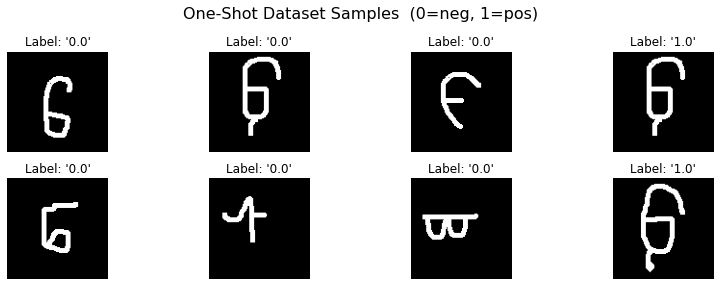

In [54]:
BATCH_SIZE = 32
SET_SIZE = 1000

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

data_dir='../../data'
train_categories = ['Greek','Tagalog','Latin','']
# use helper to create the dataloaders
train_set = OmniglotDataset(root=data_dir, set_size=SET_SIZE, 
                            categories=train_categories,
                            train=True, download=True, 
                            transform=data_transforms['train'])

test_categories = ['Mongolian']
val_set = OmniglotDataset(root=data_dir, set_size=SET_SIZE, 
                            categories=test_categories,
                            train=False, download=True, 
                            transform=data_transforms['val'])


# make the dataloader
dataloaders = {}
image_datasets = {'train':train_set, 'val':val_set}
for x in image_datasets:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
# collect the dataset size and class names
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
class_names = image_datasets['train'].classes

# # preview the dataset
oneshot_dataset_preview(dataloaders['val'])

In [58]:
# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes this should
# be well suited. DO NOT PRETRAIN FOR BASE MODEL.
model = SiameseNet()

# 
output_dir='output'
num_epochs = 50
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged

# move model to the GPU
cudnn.benchmark = True

# use helper function to train the model (outputs model and Pandas DF)
print(f'\nTraining One-shot model')
model, results_df,_ = train_oneshot(device, model, dataloaders, 
                                       dataset_sizes, output_dir=output_dir, 
                                       num_epochs=num_epochs)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'oneshot_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df.to_csv(os.path.join(output_dir,results_file),
                  columns=results_df.columns)
print(f'> Saved results to \'{results_file}\'.')


Training One-shot model

Epoch 0/49
----------


IsADirectoryError: Caught IsADirectoryError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "../common/oneshot.py", line 726, in __getitem__
    img1 = PIL.Image.open(os.path.join(imgDir1, img1Name))
  File "/opt/conda/lib/python3.7/site-packages/PIL/Image.py", line 2891, in open
    fp = builtins.open(filename, "rb")
IsADirectoryError: [Errno 21] Is a directory: '../../data/Omniglot/images_background/Syriac_(Estrangelo)/character10'


Index(['device', 'epoch', 'average_training_loss', 'average_validation_loss',
       'training_acc', 'validaton_acc', 'training_time', 'validation_time'],
      dtype='object')


<AxesSubplot:xlabel='epoch'>

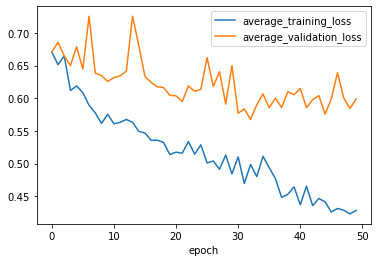

In [14]:
print(results_df.columns)
results_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'], style='-')

In [ ]:
# get the data into the right format
# img1, img2, labels


https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a#bc   

In a Siamese network, a single number is output from the model. This number represents how similar the two inputs are, where a larger number implies that the two images are more similar.

In other words, if the current iteration is an odd number, we retrieve a pair of images from the same character, and vice versa. This ensures that our training dataset is balanced for both types of outputs.

## Validation
Refer to this to get accuracy:   
https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d   

__Possible Hyperparams:__   
optimizer = Adam(lr = 0.00006)   
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [2]:
BATCH_SIZE = 32
SET_SIZE = 1000

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

data_dir='../../data'
train_set = OneShotSubLoader(root=data_dir,train=True, 
                           download=False, #categories=[1,2,3],
#                             sample_size=100,
#                              set_size = 1000,
                           transform=data_transforms['train']) 

# data_dir='../../data'
# train_categories = ['Greek','Tagalog','Latin','']
# # use helper to create the dataloaders
# train_set = OmniglotDataset(root=data_dir, set_size=SET_SIZE, 
#                             categories=train_categories,
#                             train=True, download=True, 
#                             transform=data_transforms['train'])

In [1]:
import sys
import torch
import torchvision
from torchvision import datasets, models, transforms
sys.path.insert(0, '../common/')
from oneshot import *

BATCH_SIZE = 32
SET_SIZE = 1000

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5))
    ]),
}

data_dir='../../data'
# mnist_set_subloaded = OneShotSubLoader(root=data_dir,train=True, 

mnist_set_subloaded = TestSubLoader(root=data_dir,train=True, 
                                   download=True,
                                   transform=transforms.Compose([transforms.ToTensor()])) 

mnist_set_primary = torchvision.datasets.MNIST(root=data_dir,train=True, 
                                   download=True,
                                   transform=transforms.Compose([transforms.ToTensor()]))
                                    

subloaded_loader = torch.utils.data.DataLoader(mnist_set_subloaded,
                                               shuffle=True,
                                               num_workers=2,
                                               batch_size=10)

primary_loader = torch.utils.data.DataLoader(mnist_set_primary,
                                               shuffle=True,
                                               num_workers=2,
                                               batch_size=10)

for i, ((sub_image,sub_target),(pri_image,pri_target)) \
        in enumerate(zip(subloaded_loader,primary_loader)):

    if i%10 == 0:
        print(f'__main__ sub_image: {sub_image.shape}') 
        print(f'__main__ pri_image: {pri_image.shape}') 
        break



__main__ sub_image: torch.Size([10, 1, 28, 28])
__main__ pri_image: torch.Size([10, 1, 28, 28])


## Training Siamese Network
The Siamese network we chose to use was designed for the Omniglot dataset, a 1-channel dataset well known to be used for one-shot learning. The difference is that the MNIST has images of size 28x28 while the Omniglot has images of size 105x105. As such, we chose to resize our inputs to 105x105 to take full advantage of the established network. Both references below chose to use the Admam optimizer and binary cross entropy with a sigmoid output for the network (since our classes are 1=positive set, 0=negative set). An alternative loss function that might be considered is the [triplet loss](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html) function. 

References:   
[1] https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a#bc
[2] https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d 

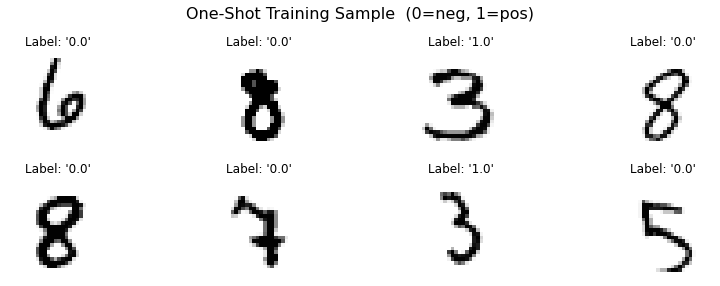

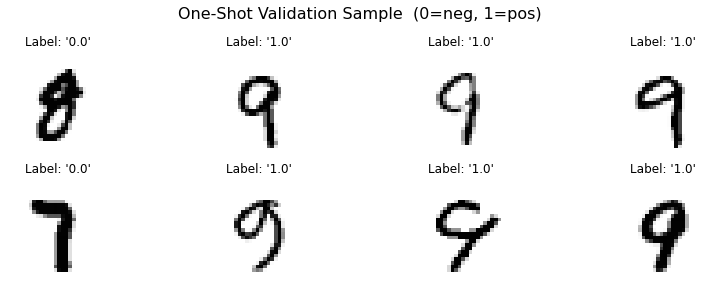

In [49]:
# Hperparameters
BATCH_SIZE = 32
SET_SIZE = 1000 # one-shot,SET_SIZE # of pairs
LR = 0.00006 # per references 1 and 2



data_transforms = {
    'train': transforms.Compose([
#         transforms.Resize(105),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
#         transforms.Resize(105),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

data_dir='../../data'
train_positive = 3
# use helper to create the dataloaders
train_set = OneShotMNIST(root=data_dir, set_size=SET_SIZE, 
                                    positive_class=train_positive,
                                    train=True, download=True, 
                                    transform=data_transforms['train'])

test_positive = 9
val_set = OneShotMNIST(root=data_dir, set_size=SET_SIZE,
                                    positive_class=test_positive,
                                    train=False, download=True, 
                                    transform=data_transforms['val'])


# make the dataloader
dataloaders = {}
image_datasets = {'train':train_set, 'val':val_set}
for x in image_datasets:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
# collect the dataset size and class names
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
class_names = image_datasets['train'].classes

# # preview the dataset
oneshot_dataset_preview(dataloaders['train'],'One-Shot Training Sample')
oneshot_dataset_preview(dataloaders['val'],'One-Shot Validation Sample')

In [50]:
# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes this should
# be well suited. DO NOT PRETRAIN FOR BASE MODEL.
# model = SimpleSiameseNet()
model = SimpleSiameseNet()


# 
output_dir='output'
num_epochs = 50
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged

# move model to the GPU
cudnn.benchmark = True

# show the model
# print(model)
# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # binary cross entropy
optimizer = Adam(model.parameters(), lr = LR)
# criterion = nn.TripletMarginLoss(margin = 1, p = 1) # https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html
# use helper function to train the model (outputs model and Pandas DF)
print(f'\nTraining One-shot model')
# model, results_df,_ = train_oneshot(device, model, dataloaders, dataset_sizes
model, results_df,_ = train_oneshot2(device, model, dataloaders, dataset_sizes,                                    
                                    criterion=criterion,optimizer=optimizer, 
                                    output_dir=output_dir, num_epochs=num_epochs)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'oneshot_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df.to_csv(os.path.join(output_dir,results_file),
                  columns=results_df.columns)
print(f'> Saved results to \'{results_file}\'.')


Training One-shot model

Epoch 0/49
----------


IndexError: index 38 is out of bounds for dimension 0 with size 32

In [15]:
# training and validation loss were calculated after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion):
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_running_loss = 0.0
        
        #check validation loss after every epoch
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
    print("Finished Training")  
    return train_losses, val_losses  
            
train(model,dataloaders['train'],dataloaders['val'],num_epochs,criterion)

Starting epoch 1
Epoch [1/50],Train Loss: 0.0019, Valid Loss: 2.09665391
Starting epoch 2
Epoch [2/50],Train Loss: 0.0017, Valid Loss: 2.13326539
Starting epoch 3
Epoch [3/50],Train Loss: 0.0015, Valid Loss: 2.17531412
Starting epoch 4
Epoch [4/50],Train Loss: 0.0013, Valid Loss: 2.21654737
Starting epoch 5
Epoch [5/50],Train Loss: 0.0012, Valid Loss: 2.23755214
Starting epoch 6
Epoch [6/50],Train Loss: 0.0011, Valid Loss: 2.27683970
Starting epoch 7
Epoch [7/50],Train Loss: 0.0009, Valid Loss: 2.33365384
Starting epoch 8
Epoch [8/50],Train Loss: 0.0009, Valid Loss: 2.34373240
Starting epoch 9
Epoch [9/50],Train Loss: 0.0008, Valid Loss: 2.34131738
Starting epoch 10
Epoch [10/50],Train Loss: 0.0007, Valid Loss: 2.44075560
Starting epoch 11
Epoch [11/50],Train Loss: 0.0007, Valid Loss: 2.38090582
Starting epoch 12
Epoch [12/50],Train Loss: 0.0006, Valid Loss: 2.41240919
Starting epoch 13
Epoch [13/50],Train Loss: 0.0006, Valid Loss: 2.46239228
Starting epoch 14
Epoch [14/50],Train Loss:

KeyboardInterrupt: 

In [8]:
def train_oneshot2(device, model, dataloaders, dataset_sizes, 
                criterion=None, optimizer=None, scheduler=None, 
                num_epochs=100, checkpoints=10, output_dir='output', 
                status=10, train_acc=0, track_steps=False,
                seed=414921):
    ''' Helper function to train One-shot model based on parameters '''
    # pylint: disable=no-member 
    # # <-- VC code pylint complains about torch.sum() and .max()

    # TODO: make a for loop similar to other training function
    train_loader = dataloaders['train']
    val_loader = dataloaders['val']
    # create the model directory if it doesn't exist
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    # configure the training if it was not specified by user
    # ref 1: https://towardsdatascience.com/building-a-one-shot- \
    #       learning-network-with-pytorch-d1c3a5fafa4a#bc
    # ref 2: https://becominghuman.ai/siamese-networks-algorithm- \
    #       applications-and-pytorch-implementation-4ffa3304c18
    if not criterion:
        criterion = nn.BCEWithLogitsLoss()
    if not optimizer:
        optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    if not scheduler:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    # send the model to the device
    model = model.to(device)
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    metrics = []
    step_metrics = [] # if track_steps=True
    training_step = 0
    acc_reached = False
    for epoch in range(num_epochs):
        training_start_time = time.time()
        if (epoch) % status == 0 or epoch == num_epochs-1:
            print()
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
        
        model.train()
        # for phase in ['train', 'val']:
        #     if phase == 'train':
        #         model.train()
        #     else:
        #         model.eval()

        epoch_phase_start_time = time.time()
        train_running_loss = 0.0
        train_running_corrects = 0.0
        # for oneshot, we have two input images and a label
        # where label:0=neg and label:1=pos 
        for img1, img2, labels in train_loader:
            step_start_time = time.time()
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)            
            # check if model predicted the match (1=correct)
            pred = labels[torch.argmax(outputs)]
            loss = criterion(outputs, labels)
            
            # for visualizing every so many epochs
            #if (epoch) % status == 0:
            #    train_peak(img1,img2,labels,outputs)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            train_running_corrects += pred.item() #torch.sum(preds == labels.data)

            if track_steps:
                # store per step metrics (WARNING! lots of data)
                step_metrics.append({
                    'device': str(device),
                    'epoch': epoch,
                    'training_step': training_step,
                    'training_step_loss': loss.item(),
                    'training_step_time': time.time() - step_start_time
                })
            training_step += 1

        # TODO: implement scheduling
        # if phase == 'train':
        #     scheduler.step()
        avg_train_loss = train_running_loss / len(train_loader)
        avg_train_acc = train_running_corrects / len(train_loader)
        
        # train_losses.append(avg_train_loss)
        val_running_loss = 0.0
        val_running_corrects = 0.0

        training_end_time = time.time()
        
        #check validation loss after every epoch
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                # check if model predicted the match (1=correct)
                pred = labels[torch.argmax(outputs)]            
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                val_running_corrects += pred.item() #torch.sum(preds == labels.data)
        avg_val_loss = val_running_loss / len(val_loader)
        avg_val_acc = val_running_corrects / len(val_loader)

        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        # val_losses.append(avg_val_loss)

        # print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
        #     .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if (epoch) % status == 0 or epoch == num_epochs-1 or acc_reached:
            # print(f'{phase} Loss: {round(epoch_loss, 4)} Acc: {round(epoch_acc.item(), 4)}')
            print(f'Train Loss: {round(avg_train_loss, 4)} Train Acc: {round(avg_train_acc, 4)}')
            print(f'Val Loss: {round(avg_val_loss, 4)} Val Acc: {round(avg_val_acc, 4)}')

        else:
            prog = '-' * int(((epoch) % status))
            print('\r{}|{}'.format(prog,epoch),end='')
        # store per epoch metrics
        metrics.append({
                        'device': str(device),
                        'epoch': epoch,
                        'average_training_loss': avg_train_loss, 
                        'average_validation_loss': avg_val_loss,
                        'training_acc': avg_train_acc,
                        'validaton_acc': avg_val_acc,
                        'training_time': training_end_time - training_start_time,
                        'validation_time': time.time() - training_end_time
                    })
    print("Finished Training")  

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {round(best_acc, 4)}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    # set up return structures
    metrics_df = pd.DataFrame(data=metrics)
    step_metrics_df = pd.DataFrame(data=step_metrics) if step_metrics else None

    return model, metrics_df, step_metrics_df  

Index(['device', 'epoch', 'average_training_loss', 'average_validation_loss',
       'training_acc', 'validaton_acc', 'training_time', 'validation_time'],
      dtype='object')


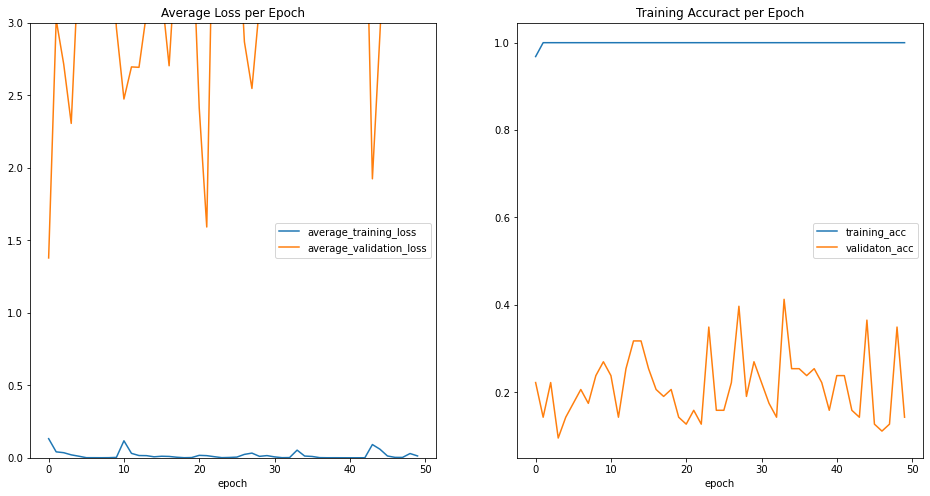

In [48]:
print(results_df.columns)
# fig = results_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'], style='-', figsize=(12, 10)).get_figure()
# plt.show()
# fig.savefig(os.path.join(output_dir,img_file))

# results_df.plot(x='epoch', y=['training_acc','validaton_acc'], style='-', figsize=(8, 10))

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
results_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
results_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

plt.show()

## Compare all of the training/validation times
df = resnet18_df.set_index('epoch').copy()
df['model'] = 'resnet18'
# concatenetate all model results and sum up the times
time_df = df.groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig = time_df.plot.bar(figsize=(8,6))
plt.title('Showing Total Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()